In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import folium
import requests
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # For principle components analysis
from scipy.spatial.distance import cdist
from geopy.distance import geodesic # For determining distances in various units between locations
from matplotlib.colors import Normalize,rgb2hex # For visualization of groups
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D # For 3d graphics
import seaborn as sns # For visualization modifications within this analysis
%matplotlib notebook

# Custom library: For getting client and secret id's without showing sensitive information explicitly
# For replication purposes, one can remove the following 3 lines and replace client and secret with their respective
# values when using the Foursquare API
from env_tools import prepare_env
prepare_env("fsq")
import os
client = os.environ["fsq_client"]
secret = os.environ['fsq_secret']

In [3]:
toronto_nb = pd.read_csv("datasets/toronto_neighborhoods.csv")
coordinate_dataframe = pd.read_csv("datasets/toronto_nb_coords.csv")

In [4]:
display(toronto_nb.head())
print("Rows, Columns:")
toronto_nb.shape

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Rows, Columns:


(103, 3)

In [5]:
display(coordinate_dataframe.head())
print("Rows, Columns:")
coordinate_dataframe.shape

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Rows, Columns:


(103, 3)

In [6]:
toronto_nb = toronto_nb.merge(coordinate_dataframe,left_on='PostalCode',right_on="PostalCode") # 1 to 1 merge
display(toronto_nb.head())
print("Rows, Columns:")
print(toronto_nb.shape,'\n')

# We should expect unique postal codes and thus a sum of 0 duplicated postal codes
print("Total Duplicated PostalCodes:")
display(toronto_nb.PostalCode.duplicated().sum())
print()

# We should also expect unique postal codes and thus a sum of 0 duplicated postal codes
print("Duplicated Neighborhood Names:")
toronto_nb.Neighborhood.duplicated().sum()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Rows, Columns:
(103, 5) 

Total Duplicated PostalCodes:


0


Duplicated Neighborhood Names:


0

In [7]:
# Each postal code is mapped to a location dictionary to more quickly pass location data to functions 
# expecting iterable locations
toronto_nb['Location'] = [(lat,lon) for lat, lon in zip(toronto_nb.Latitude.values, toronto_nb.Longitude.values)]
pc_location_dict = pd.Series(data = toronto_nb.Location.values, index = toronto_nb.Neighborhood.values).to_dict()
pc_location_dict

{'Rouge, Malvern': (43.806686299999996, -79.19435340000001),
 'Highland Creek, Rouge Hill, Port Union': (43.78453510000001,
  -79.16049709999999),
 'Guildwood, Morningside, West Hill': (43.7635726, -79.1887115),
 'Woburn': (43.7709921, -79.21691740000001),
 'Cedarbrae': (43.773136, -79.23947609999998),
 'Scarborough Village': (43.7447342, -79.23947609999998),
 'East Birchmount Park, Ionview, Kennedy Park': (43.7279292,
  -79.26202940000002),
 'Clairlea, Golden Mile, Oakridge': (43.711111700000004, -79.2845772),
 'Cliffcrest, Cliffside, Scarborough Village West': (43.716316,
  -79.23947609999998),
 'Birch Cliff, Cliffside West': (43.653226000000004, -79.3831843),
 'Dorset Park, Scarborough Town Centre, Wexford Heights': (43.7574096,
  -79.27330400000001),
 'Maryvale, Wexford': (43.750071500000004, -79.2958491),
 'Agincourt': (43.7942003, -79.26202940000002),
 "Clarks Corners, Sullivan, Tam O'Shanter": (43.7816375, -79.3043021),
 "Agincourt North, L'Amoreaux East, Milliken, Steeles East"

In [8]:
# This function is for general use as a potential future simplification of the processes of requesting data
# from the foursquare api without needing to type the entire url as one string:
def fsq_params(location,radius=None,limit=None,date=dt.now(),client=client,secret=secret):
    
    #foursquare expects latitude and longitude separated by a single comma:
    formatted_location = "{},{}".format(location[0],location[1])
    
    # The version requested is the most recent:
    formatted_date = "{y}{m:02d}{d:02d}".format(y=date.year,m=date.month,d=date.day) 
    
    params = {"v":formatted_date,"client_id":client,'client_secret':secret,'ll':formatted_location}
    if radius is not None:
        params['radius'] = radius
    if limit is not None:
        params['limit'] = limit
    return params

In [9]:
# The following function takes 1 neighborhood value given that the neighborhood is mapped to a given location:
def getNearbyVenues(neighborhood, pc_location_dict=pc_location_dict, radius=500,limit=1000):
    location = pc_location_dict[neighborhood]
                
    # specify the API request URL endpoint
    url = 'https://api.foursquare.com/v2/venues/explore'

    # specify the parameters for the API request
    params = fsq_params(location,radius=radius,limit=limit)
    
    # make the GET request
    results = requests.get(url,params=params).json()["response"]['groups'][0]['items']

    # retrieve only relevant information for each nearby venue from the results of the API call
    venues_list=[[neighborhood, location, v['venue']['name'],
                 (v['venue']['location']['lat'], v['venue']['location']['lng']), 
                 v['venue']['categories'][0]['name'], v['reasons']['items'][0]['summary']] for v in results]
    
    columns = ['Neighborhood', 'Neighborhood Location',
               'Venue', 'Venue Location', 'Venue Category','Summary']
    
    # return a dataframe for the specified columns where each row denotes a single venue for the queried neighborhood location
    nearby_venues = pd.DataFrame(venues_list,columns=columns)
    return nearby_venues

In [10]:
try:
    
    nearby_venue_dataframe = pd.read_csv("datasets/nearby_venues.csv")
    
except FileNotFoundError:
    venue_dataframes=[getNearbyVenues(neighborhood) for neighborhood in toronto_nb['Neighborhood'].values]
    nearby_venue_dataframe = pd.concat(venue_dataframes)
    nearby_venue_dataframe.to_csv("datasets/nearby_venues.csv",index=False)
else:
    # if the read_csv was successful, prepare the data:
    
    # because the location data is formatted and saved as a tuple and subsequently converted to a string 
    # when re-read, this function is then used to parse 1d iterables (lists and tuples) containing numbers
    # that were formatted as strings
    def str_iterable2float(str_iterable):
        return tuple(
                      float(numerical_str) for numerical_str in str_iterable
                     .replace("[","").replace("]","")
                     .replace("(","").replace(")","").split(', ')
                    )
    
    nearby_venue_dataframe['Neighborhood Location'] = nearby_venue_dataframe['Neighborhood Location'].apply(str_iterable2float)
    nearby_venue_dataframe['Venue Location'] = nearby_venue_dataframe['Venue Location'].apply(str_iterable2float)

In [11]:
def len_distinct(obj):
    return len(set(obj))

grouped_neighborhood_venues = nearby_venue_dataframe.groupby(["Neighborhood"])
nb_venue_totals = grouped_neighborhood_venues.apply(len) # get the total amount of venues nearby each neighborhood

# get the total unique venue categories within each neighborhood
nb_unique_venue_totals = grouped_neighborhood_venues['Venue Category'].apply(len_distinct)
nb_unique_venue_totals_dict = nb_unique_venue_totals.to_dict()

nearby_venue_dataframe['Distinct Venue Type Count'] = nearby_venue_dataframe['Neighborhood'].map(nb_unique_venue_totals)
nearby_venue_dataframe['Total Venues'] = nearby_venue_dataframe['Neighborhood'].map(nb_venue_totals)

# For each neighborhood, divide its total amount of venue categories by its total number of venues
nearby_venue_dataframe['Weighted Unique Venues'] = nearby_venue_dataframe['Distinct Venue Type Count'] / nearby_venue_dataframe['Total Venues']
nearby_venue_dataframe["Relative Venue Totals"] = nearby_venue_dataframe['Total Venues'] / nearby_venue_dataframe['Total Venues'].max()
nearby_venue_dataframe

,Neighborhood,Neighborhood Location,Venue,Venue Location,Venue Category,Summary,Distinct Venue Type Count,Total Venues,Weighted Unique Venues,Relative Venue Totals
0,"Rouge, Malvern","(43.806686299999996, -79.19435340000001)",Wendy's,"(43.80744841934756, -79.19905558052072)",Fast Food Restaurant,This spot is popular,1,1,1.000000,0.01
1,"Highland Creek, Rouge Hill, Port Union","(43.78453510000001, -79.16049709999999)",Royal Canadian Legion,"(43.78253332838298, -79.16308473261682)",Bar,This spot is popular,1,1,1.000000,0.01
2,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Swiss Chalet Rotisserie & Grill,"(43.76769708292701, -79.1899135003439)",Pizza Place,This spot is popular,7,7,1.000000,0.07
3,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",G & G Electronics,"(43.765309, -79.191537)",Electronics Store,This spot is popular,7,7,1.000000,0.07
4,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Big Bite Burrito,"(43.766299084470795, -79.19071980583941)",Mexican Restaurant,This spot is popular,7,7,1.000000,0.07
5,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",chatr Mobile,"(43.765917, -79.191672)",Tech Startup,This spot is popular,7,7,1.000000,0.07
6,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Enterprise Rent-A-Car,"(43.7640757, -79.1934057)",Rental Car Location,This spot is popular,7,7,1.000000,0.07
7,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Woburn Medical Centre,"(43.766631153138455, -79.19228553771973)",Medical Center,This spot is popular,7,7,1.000000,0.07
8,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Eggsmart,"(43.7678, -79.190466)",Breakfast Spot,This spot is popular,7,7,1.000000,0.07
9,Woburn,"(43.7709921, -79.21691740000001)",Starbucks,"(43.770037201625215, -79.22115586641958)",Coffee Shop,This spot is popular,2,3,0.666667,0.03


In [12]:
# find the distance in meters between two locations (by latitude and longitude)
def location_dist(location1,location2):
    distance =geodesic(location1,location2).m
    return distance
    
# iterate through the dataframe of neighborhood-venue locations using a list comprehension:
nearby_venue_dataframe['Distance (m) From Neighborhood'] = [
    location_dist(n_loc,v_loc) for n_loc,v_loc
    in zip(nearby_venue_dataframe['Venue Location'].values,
           nearby_venue_dataframe['Neighborhood Location'].values)
]

# find the mean distance of each venue from its respective neighborhood, and record the resulting series as a column
nearby_venue_dataframe['Mean Venue Distance (m) From Neighborhood'] =  (
    nearby_venue_dataframe
    .groupby("Neighborhood")['Distance (m) From Neighborhood']
    .transform(np.mean)
)
nearby_venue_dataframe

,Neighborhood,Neighborhood Location,Venue,Venue Location,Venue Category,Summary,Distinct Venue Type Count,Total Venues,Weighted Unique Venues,Relative Venue Totals,Distance (m) From Neighborhood,Mean Venue Distance (m) From Neighborhood
0,"Rouge, Malvern","(43.806686299999996, -79.19435340000001)",Wendy's,"(43.80744841934756, -79.19905558052072)",Fast Food Restaurant,This spot is popular,1,1,1.000000,0.01,387.723669,387.723669
1,"Highland Creek, Rouge Hill, Port Union","(43.78453510000001, -79.16049709999999)",Royal Canadian Legion,"(43.78253332838298, -79.16308473261682)",Bar,This spot is popular,1,1,1.000000,0.01,304.721559,304.721559
2,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Swiss Chalet Rotisserie & Grill,"(43.76769708292701, -79.1899135003439)",Pizza Place,This spot is popular,7,7,1.000000,0.07,468.371008,397.295779
3,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",G & G Electronics,"(43.765309, -79.191537)",Electronics Store,This spot is popular,7,7,1.000000,0.07,298.303641,397.295779
4,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Big Bite Burrito,"(43.766299084470795, -79.19071980583941)",Mexican Restaurant,This spot is popular,7,7,1.000000,0.07,343.394414,397.295779
5,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",chatr Mobile,"(43.765917, -79.191672)",Tech Startup,This spot is popular,7,7,1.000000,0.07,353.098334,397.295779
6,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Enterprise Rent-A-Car,"(43.7640757, -79.1934057)",Rental Car Location,This spot is popular,7,7,1.000000,0.07,382.104995,397.295779
7,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Woburn Medical Centre,"(43.766631153138455, -79.19228553771973)",Medical Center,This spot is popular,7,7,1.000000,0.07,445.315333,397.295779
8,"Guildwood, Morningside, West Hill","(43.7635726, -79.1887115)",Eggsmart,"(43.7678, -79.190466)",Breakfast Spot,This spot is popular,7,7,1.000000,0.07,490.482730,397.295779
9,Woburn,"(43.7709921, -79.21691740000001)",Starbucks,"(43.770037201625215, -79.22115586641958)",Coffee Shop,This spot is popular,2,3,0.666667,0.03,357.371061,349.743493


In [13]:
nearby_venue_dataframe.Summary.value_counts() # With all queried venues being shown as popular, this variable 
                                              # may not be preferable to include as a K-means feature

This spot is popular    2419
Name: Summary, dtype: int64

In [14]:
# Transform the various possible venue categories into indicator variables:
one_hot = pd.get_dummies(nearby_venue_dataframe['Venue Category'])

# Set "Neighborhood" as the index for later ease of data manipulation:
one_hot['Neighborhood'] = nearby_venue_dataframe.Neighborhood.values
one_hot_grouped = one_hot.groupby("Neighborhood")

# Find the proportion of venues of each category within each neighborhood:
neighborhood_venue_weights = one_hot_grouped.mean()


In [15]:
# create a rankings index to determine most and least common neighborhood venue categories:
rankings = ['st','nd','rd'] + ['th'] * (neighborhood_venue_weights.columns.size - 3)
numerical_index = np.arange(1,neighborhood_venue_weights.columns.size+1)
ranking_index=[num+rk for num, rk in zip(numerical_index.astype('str'),rankings)]

# sort the venue categories of a given neighborhood from most commonly occurring to least commonly occurring:
def sort_venue_categories(venue_wieghts, nb_unique_venue_totals=nb_unique_venue_totals_dict,ranking_index=ranking_index):
    nb_name = venue_wieghts.name
    # Get the indices from highest to lowest weight:
    sorted_indices = np.argsort(venue_wieghts.values)[::-1]
    # Order the previous index of venue categories using the resulting sorted indices array:
    ordered_venues = venue_wieghts.index[sorted_indices]
    # create a new series of categories ranked from most frequently occurring to least:
    ranked_venues = pd.Series(ordered_venues,index=ranking_index)
    
    # if categories do not appear at all near a given neighborhood, 
    # do not record their names within the created series:
    
    # if there are three unique categories of a size 100 list, the last 97 ranked categories will == 0 and not provide
    # any new information. From the first unused category onward, values are marked as blank
    first_unused_rk = -(len(ranking_index) - nb_unique_venue_totals[nb_name])
    ranked_venues[first_unused_rk:] = ""
    
    return ranked_venues

# transform the weighted transformation of the dataframe with indicators into a dataframe with ranked venue categories
# for each neighborhood:
ranked_venues_by_nb = neighborhood_venue_weights.apply(sort_venue_categories,axis=1)
ranked_venues_by_nb

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,...,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",Coffee Shop,Café,American Restaurant,Steakhouse,Thai Restaurant,Restaurant,Gym,Clothing Store,Bakery,Asian Restaurant,...,,,,,,,,,,
Agincourt,Chinese Restaurant,Lounge,Sandwich Place,Breakfast Spot,,,,,,,...,,,,,,,,,,
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",Coffee Shop,Park,Playground,,,,,,,,...,,,,,,,,,,
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",Grocery Store,Coffee Shop,Pizza Place,Discount Store,Sandwich Place,Fried Chicken Joint,Beer Store,Japanese Restaurant,Video Store,Pharmacy,...,,,,,,,,,,
"Alderwood, Long Branch",Pizza Place,Gym,Coffee Shop,Skating Rink,Pharmacy,Athletics & Sports,Pub,Sandwich Place,Pool,,...,,,,,,,,,,
"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,Fried Chicken Joint,Frozen Yogurt Shop,Bridal Shop,Fast Food Restaurant,Sandwich Place,Diner,Restaurant,Bank,Deli / Bodega,...,,,,,,,,,,
Bayview Village,Japanese Restaurant,Chinese Restaurant,Café,Bank,,,,,,,...,,,,,,,,,,
"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Fast Food Restaurant,Sushi Restaurant,Greek Restaurant,Indian Restaurant,Grocery Store,Pharmacy,Pizza Place,Pub,...,,,,,,,,,,
Berczy Park,Coffee Shop,Cocktail Bar,Restaurant,Café,Beer Bar,Cheese Shop,Bakery,Italian Restaurant,Steakhouse,Farmers Market,...,,,,,,,,,,


In [16]:

nb_metrics_df = nearby_venue_dataframe.set_index("Neighborhood")[["Relative Venue Totals","Total Venues","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]]
feature_columns = ["Relative Venue Totals","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]

# take the columns that provide background information on each neighborhood and exclude venue information.
# delete the extra rows in order to create a 1 to 1 merge with the neighborhood venue weights dataframe.
nb_metrics_df = nb_metrics_df.loc[~nb_metrics_df.index.duplicated()]
venue_features=neighborhood_venue_weights.merge(nb_metrics_df[feature_columns],left_index=True,right_index=True)

# prepare the columns for clustering analysis by standardizing the columns:

def standardize(variable):
    return (variable - variable.mean()) / variable.std()

# normalize the data and weight the features by the length of the features minus "Totals" columns
venue_features = venue_features.apply(standardize)
total_indicators = len(one_hot.columns)


# apply an integer weights to Avg neighborhood-venue distances, "Relative Venue Totals", and "Weighted Unique Values"
# that these features are accounted in equal proportion the influence of all indicator variables combined
venue_features[["Relative Venue Totals","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]] = venue_features[["Relative Venue Totals","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]] * total_indicators 
venue_features

,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Relative Venue Totals,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood
Neighborhood,,,,,,,,,,,,,,,,,,,,,
"Adelaide, King, Richmond",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,0.806935,...,-0.150571,-0.195683,-0.1,2.858627,-0.148629,0.032247,-0.283193,660.151144,-480.422495,-106.148838
Agincourt,-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-175.813898,249.240717,-25.295222
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-184.521867,249.240717,131.835611
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,8.162549,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-106.150144,100.935186,84.482983
"Alderwood, Long Branch",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-123.566083,71.274080,-191.294445
"Bathurst Manor, Downsview North, Wilson Heights",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,5.391509,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-53.902329,150.370363,-433.227389
Bayview Village,-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,-175.813898,249.240717,309.022544
"Bedford Park, Lawrence Manor East",-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,0.806935,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,7.053455,-106.692557,-363.005909
Berczy Park,-0.162433,-0.1,-0.1,-0.123956,-0.1,-0.1,-0.1,-0.1,-0.1,-0.282600,...,-0.150571,-0.195683,-0.1,-0.308591,-0.148629,-0.155611,-0.283193,268.292531,-268.480409,252.137755


<IPython.core.display.Javascript object>


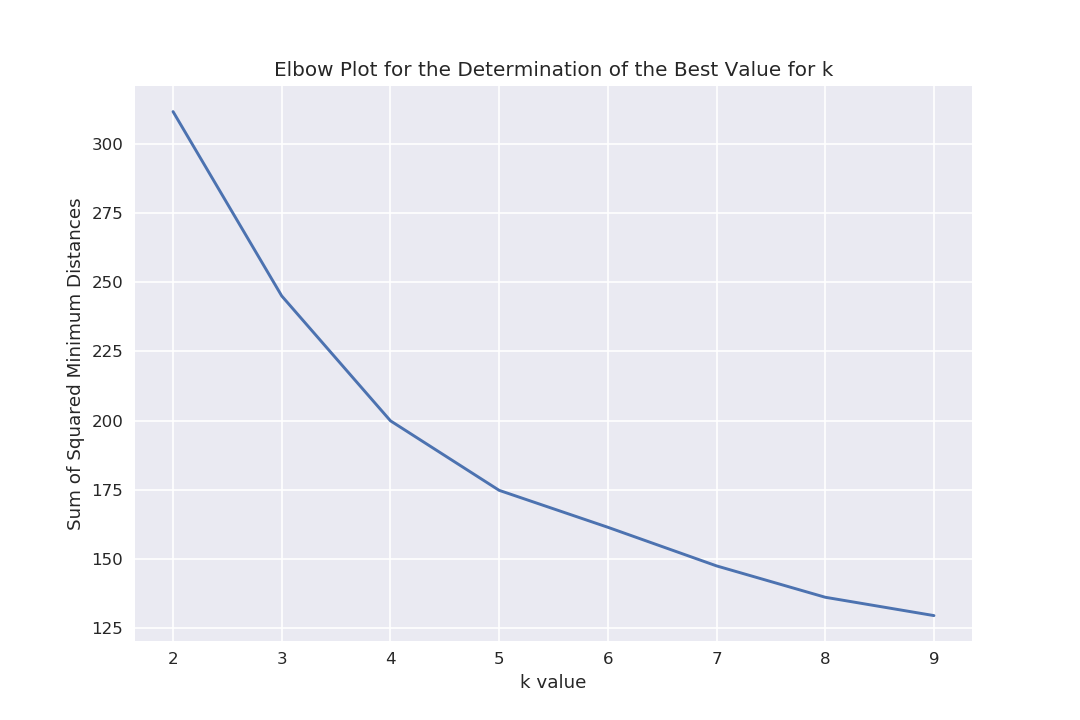

In [17]:
# K-Means:
# use what is called "The Elbow Method" to choose the most optimal value for k:
errors = []
K = range(2,10)
for k in K:
    kmeans = KMeans(n_clusters=k,random_state=3).fit(venue_features)
    kmeans.fit(venue_features)
    errors.append(np.sum(np.min(cdist(venue_features, kmeans.cluster_centers_, 'euclidean'), axis=1)) / len(venue_features))
    
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(K,errors,marker='+')
ax.set_title("Elbow Plot for the Determination of the Best Value for k")
ax.set_xlabel("k value")
ax.set_ylabel("Sum of Squared Minimum Distances")
plt.show()

** Choosing k: **

A value of 8 for k was chosen for the sake of clustering each neighborhood, as it can be seen from the above graph that there is a slight decrease in the error for this graph at this value. The choice of 8 for the value of k also manages to significantly minimize error in comparison to smaller values of k

In [18]:
# Implement the k-means algorithm while selecting the cluster centroids that minimize the error the most in 
#comparison to those of the other 299 iterations (using n_init=300)
kmeans = KMeans(n_clusters=8,random_state=3,n_init=300).fit(venue_features)

# Save the following labels as a column to be utilized later:
ranked_venues_by_nb['Cluster'] = kmeans.labels_

In [19]:
# Detail the total number of neighborhoods that have been categorized into each cluster:
print("Total neighborhoods within each cluster:")
ranked_venues_by_nb['Cluster'].value_counts().sort_index()


Total neighborhoods within each cluster:


0    10
1    19
2    13
3    12
4     7
5     9
6    15
7    15
Name: Cluster, dtype: int64

In [20]:
# Utilize the columns that haven't been standardized and are simultaneously interpretable by the average human being
# in order to derive insight from the analysis
informative_columns=["Total Venues","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]

# merge the ranked venues dataframe with the above columns in a 1 to 1 relationship
nb_venue_cluster_df = (ranked_venues_by_nb
                       .merge(nb_metrics_df[informative_columns],
                              left_index=True,
                              right_index = True)
                       .reset_index()
                       .sort_values(by="Cluster")
                       .set_index("Neighborhood")
)

# sort the columns that rankings follow the columns that are not ranks:
unranked_columns = ["Cluster","Total Venues","Weighted Unique Venues","Mean Venue Distance (m) From Neighborhood"]
ordered_columns = unranked_columns + [column for column in nb_venue_cluster_df.columns 
                                         if column not in unranked_columns]
nb_venue_cluster_df = nb_venue_cluster_df[ordered_columns]
nb_venue_cluster_df


,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,...,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,
York Mills West,0,3,0.666667,239.466082,Park,Bank,,,,,...,,,,,,,,,,
"Cabbagetown, St. James Town",0,47,0.744681,310.157245,Coffee Shop,Restaurant,Park,Bakery,Pub,Café,...,,,,,,,,,,
"Flemingdon Park, Don Mills South",0,21,0.809524,230.633708,Beer Store,Gym,Asian Restaurant,Coffee Shop,General Entertainment,Japanese Restaurant,...,,,,,,,,,,
"Runnymede, Swansea",0,36,0.750000,311.072145,Coffee Shop,Sushi Restaurant,Café,Pizza Place,Italian Restaurant,Food,...,,,,,,,,,,
"Fairview, Henry Farm, Oriole",0,65,0.661538,229.108482,Clothing Store,Fast Food Restaurant,Coffee Shop,Food Court,Shoe Store,Bus Station,...,,,,,,,,,,
"Bedford Park, Lawrence Manor East",0,25,0.800000,244.463600,Italian Restaurant,Coffee Shop,Fast Food Restaurant,Sushi Restaurant,Greek Restaurant,Indian Restaurant,...,,,,,,,,,,
"Little Portugal, Trinity",0,65,0.661538,274.658202,Bar,Men's Store,Coffee Shop,Restaurant,Asian Restaurant,Café,...,,,,,,,,,,
Davisville,0,37,0.675676,275.326921,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Café,Coffee Shop,...,,,,,,,,,,
Studio District,0,40,0.800000,273.810721,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Middle Eastern Restaurant,...,,,,,,,,,,


In [21]:
# Determine the minimum amount of components that explain for the majority of the variance between and within clusters
# while simultaneously enabling visualization of the data
pca = PCA(n_components=3)
pca.fit(venue_features)

print("Principle Components Analysis:",'\n')
print("Percentage of Variance Explained by each component:")
for rank, ratio in zip(ranking_index,pca.explained_variance_ratio_):
    print(rank+":", "{:.2%}".format(ratio))
print("\nTotal Explained Variance:\n{:.2%}".format(pca.explained_variance_ratio_.sum()))

Principle Components Analysis: 

Percentage of Variance Explained by each component:
1st: 64.52%
2nd: 30.02%
3rd: 5.35%

Total Explained Variance:
99.89%


** Interpretation: **

From what can be seen above, 3 components from the data are all that is necessary in order to better understand the similarities and differences within and between neighborhood clusters. Luckily, an accurate 3d visualization of the variance can be created as a result

In [22]:
# Each cluster is 0 indexed and will thus be presented as Cluster i + 1 in the following interpretation:
def cluster_label(num):
    return "Cluster {}".format(num + 1)

<IPython.core.display.Javascript object>


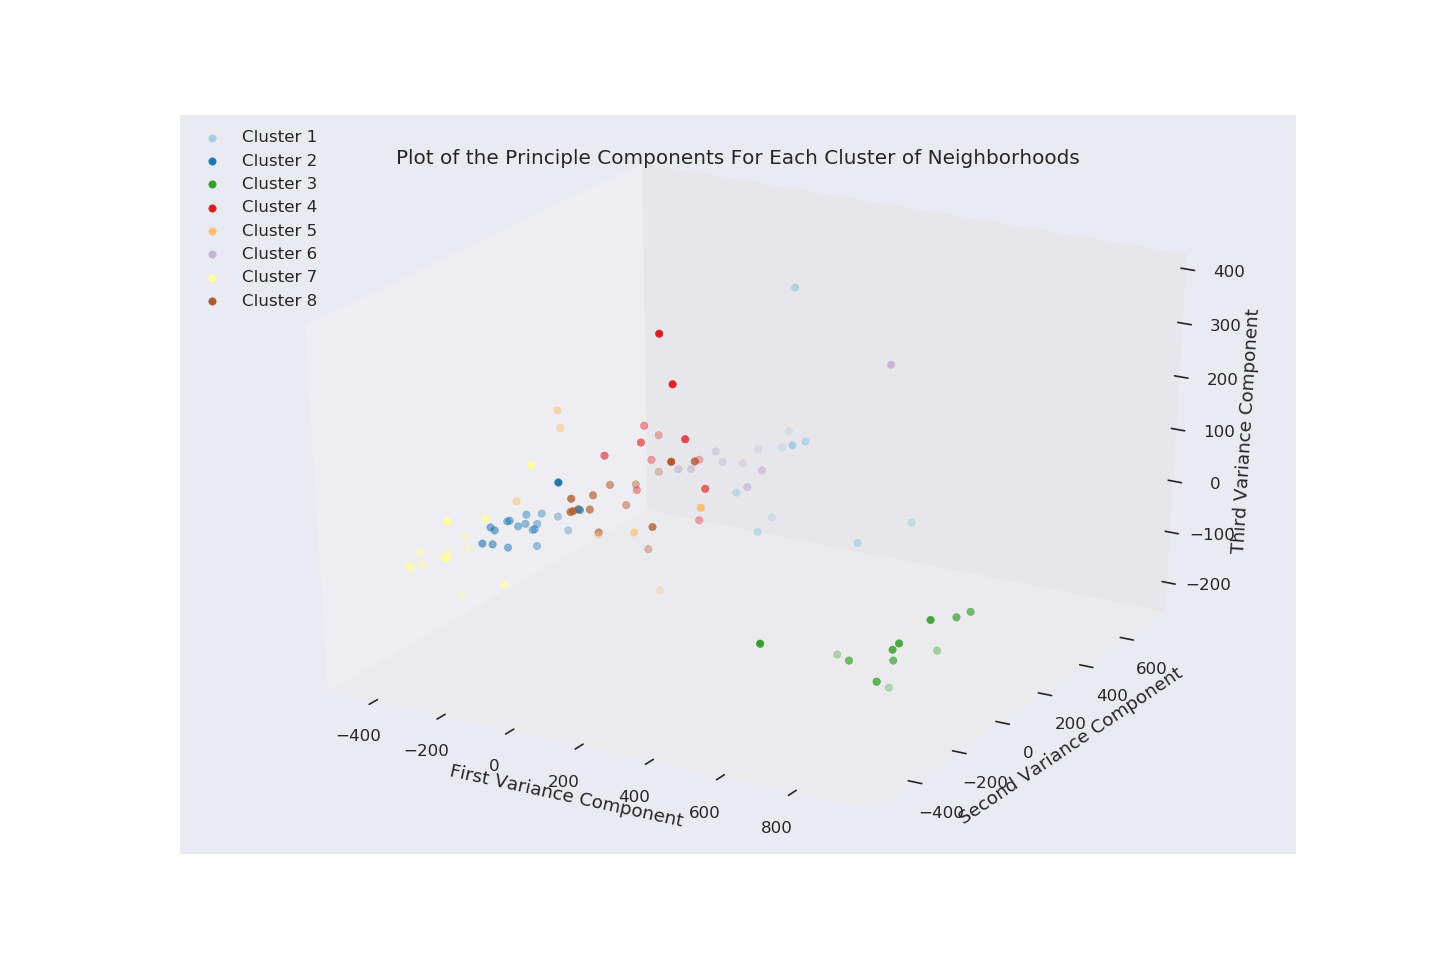

In [23]:
# Using 3 components from the PCA, the variance between and within clusters is visualized:
pca_components = pca.transform(venue_features)[:,:3]

# for customize the appearance of the following scatterplot:
sns.set_style("dark")

# create a 3d interactive scatterplot:
fig,ax=plt.subplots(figsize=(12,8),subplot_kw={'projection': '3d'})

# The following color map will is used in order to quickly identify each cluster from others:
cmap = plt.cm.Paired

# retrieve and sort the unique clusters within each group:
unique_clusters = np.sort(ranked_venues_by_nb.Cluster.unique())

# create the color map to be used in the following visualizations:
colors = cmap(np.linspace(0,1,unique_clusters.size))
#colors_dict = dict(zip(range(len(colors)),colors))
#ranked_venues_by_nb['Cluster Color'] =  ranked_venues_by_nb.map(colors_dict)
# this is a rotatable graphic

# Each color is zipped with its designated cluster in order to distinguish each cluster from others
for color, cluster in zip(colors,unique_clusters):
    cluster_components = pca_components[ranked_venues_by_nb.Cluster == cluster]
    ax.scatter(cluster_components[:,0],cluster_components[:,1],
               cluster_components[:,2],
                c=color,
               label = cluster_label(cluster)
              )
ax.legend(loc=2)
    
ax.set_xlabel("First Variance Component")
ax.set_ylabel("Second Variance Component")
ax.set_zlabel("Third Variance Component")
ax.set_title("Plot of the Principle Components For Each Cluster of Neighborhoods")
ax.grid(False)

In [24]:
# merge the cluster information with the location of each neighborhood visualize the resulting clusters:
neighborhood_locations_df = toronto_nb.set_index("Neighborhood").rename(columns={"Latitude":"Nb Lat","Longitude":"Nb Lon"})[["Nb Lat","Nb Lon"]]
nb_cluster_locations_df = nb_venue_cluster_df.merge(neighborhood_locations_df,left_index=True,right_index=True)

toronto_lat = 43.761539
toronto_lon = -79.411079

# create an efficient to query dictionary for clusters and their resulting rgba colors
colors_dict = dict(zip(unique_clusters,[rgb2hex(color) for color in colors]))

# create map
toronto_nb_cluster_map = folium.Map(location=[toronto_lat, toronto_lon], zoom_start=11)

# add markers to the map
for lat, lon, name, cluster in zip(nb_cluster_locations_df["Nb Lat"], nb_cluster_locations_df["Nb Lon"], nb_cluster_locations_df.index, nb_cluster_locations_df['Cluster']):
    nb_label = name + ' ('+ cluster_label(cluster) + ')'
    popup_label = folium.Popup(nb_label, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=popup_label,
        color=colors_dict[cluster],
        fill=True,
        fill_color=colors_dict[cluster],
        fill_opacity=.8
    ).add_to(toronto_nb_cluster_map)
       
toronto_nb_cluster_map

In [25]:
nb_features = ['Mean Venue Distance (m) From Neighborhood', 'Total Venues', 'Weighted Unique Venues']
nb_venue_cluster_df[nb_features].describe()

,Mean Venue Distance (m) From Neighborhood,Total Venues,Weighted Unique Venues
count,100.000000,100.000000,100.000000
mean,342.113145,24.190000,0.859951
std,74.244726,31.695105,0.155085
min,137.242785,1.000000,0.520000
25%,297.116060,4.000000,0.740966
50%,338.680008,8.500000,0.911067
75%,398.313817,33.250000,1.000000
max,486.735086,100.000000,1.000000


In [26]:
pd.set_option("display.max_columns",None)
nb_venue_cluster_df.groupby("Cluster").describe()

Mean Venue Distance (m) From Neighborhood                         \
                                            count        mean        std   
Cluster                                                                    
0                                            10.0  269.719515  32.747661   
1                                            19.0  381.263628  18.077589   
2                                            13.0  310.694270  32.715948   
3                                            12.0  335.440336  21.191594   
4                                             7.0  418.181477  19.225911   
5                                             9.0  208.659618  33.276541   
6                                            15.0  450.178502  20.628179   
7                                            15.0  309.861096  25.210283   

                                                                     \
                min         25%         50%         75%         max   
Cluster                                                               
0        229.108482  240.715462  274.234462  300.205263  311.072145   
1        349.154403  370.981886  377.577271  393.464076  414.021747   
2        263.613418  297.047972  313.663040  320.328416  392.503094   
3        295.242677  323.196406  341.901420  349.762496  367.197448   
4        393.827953  410.646445  414.581292  420.546954  456.474292   
5        137.242785  199.579383  214.395420  225.573838  249.564717   
6        415.368658  441.326470  444.601445  467.098200  486.735086   
7        264.785791  293.896596  306.819748  331.601453  341.723094   

        Total Venues                                                     \
               count       mean        std   min     25%    50%     75%   
Cluster                                                                   
0               10.0  38.100000  18.993859   3.0   27.75   38.5   45.75   
1               19.0   4.473684   3.115703   1.0    2.00    4.0    6.00   
2               13.0  97.153846   5.885663  83.0  100.00  100.0  100.00   
3               12.0  16.416667   9.894519   3.0   10.00   14.5   20.25   
4                7.0  30.142857  20.243753   4.0   13.00   35.0   45.50   
5                9.0   8.333333   6.204837   2.0    4.00    5.0   15.00   
6               15.0   6.933333   6.215955   1.0    3.50    4.0    8.50   
7               15.0   6.866667   5.962582   1.0    2.50    4.0   10.50   

               Weighted Unique Venues                                          \
           max                  count      mean       std       min       25%   
Cluster                                                                         
0         65.0                   10.0  0.718867  0.070037  0.619048  0.662821   
1         12.0                   19.0  0.989035  0.033570  0.875000  1.000000   
2        100.0                   13.0  0.595964  0.050819  0.520000  0.550000   
3         34.0                   12.0  0.784259  0.070985  0.666667  0.728554   
4         55.0                    7.0  0.718921  0.055158  0.612245  0.699784   
5         18.0                    9.0  0.964660  0.066851  0.800000  0.944444   
6         23.0                   15.0  0.959018  0.061957  0.833333  0.900966   
7         19.0                   15.0  0.983764  0.034929  0.900000  1.000000   

                                       
              50%       75%       max  
Cluster                                
0        0.710178  0.787500  0.809524  
1        1.000000  1.000000  1.000000  
2        0.610000  0.630000  0.686047  
3        0.818182  0.835526  0.857143  
4        0.742857  0.750000  0.777778  
5        1.000000  1.000000  1.000000  
6        1.000000  1.000000  1.000000  
7        1.000000  1.000000  1.000000

In [27]:
print("Proportion of Venues of each Category Within Each Cluster")
print("-"*57,'\n')
for cluster in unique_clusters:
    print("Most common values for Cluster", cluster + 1)
    print("-"*32)
    nb_venue_cluster_data = nb_venue_cluster_df.loc[nb_venue_cluster_df["Cluster"] == cluster,ranking_index].values
    cluster_size = len(nb_venue_cluster_data)
    cluster_frequencies = pd.value_counts(nb_venue_cluster_data.flatten()).sort_values(ascending=False).head(11) / cluster_size
    display(cluster_frequencies.loc[cluster_frequencies.index != ''])
    print("\n")
    pass

Proportion of Venues of each Category Within Each Cluster
--------------------------------------------------------- 

Most common values for Cluster 1
--------------------------------


Coffee Shop            0.9
Italian Restaurant     0.8
Restaurant             0.8
Pizza Place            0.7
American Restaurant    0.6
Café                   0.6
Sandwich Place         0.6
Diner                  0.6
Pharmacy               0.5
Pub                    0.5
dtype: float64



Most common values for Cluster 2
--------------------------------


Park                    0.315789
Coffee Shop             0.263158
Baseball Field          0.157895
Pizza Place             0.157895
Discount Store          0.157895
Gym / Fitness Center    0.105263
Sandwich Place          0.105263
Pharmacy                0.105263
Japanese Restaurant     0.105263
Grocery Store           0.105263
dtype: float64



Most common values for Cluster 3
--------------------------------


Coffee Shop            1.000000
Café                   1.000000
Pizza Place            1.000000
American Restaurant    0.923077
Restaurant             0.923077
Bakery                 0.923077
Seafood Restaurant     0.923077
Hotel                  0.846154
Japanese Restaurant    0.846154
Steakhouse             0.846154
dtype: float64



Most common values for Cluster 4
--------------------------------


Coffee Shop           0.666667
Café                  0.500000
Sandwich Place        0.416667
Pharmacy              0.333333
Park                  0.333333
Italian Restaurant    0.250000
Bank                  0.250000
Liquor Store          0.250000
Grocery Store         0.250000
Pizza Place           0.250000
dtype: float64



Most common values for Cluster 5
--------------------------------


Coffee Shop             0.714286
Park                    0.714286
Fast Food Restaurant    0.571429
Café                    0.571429
Bakery                  0.428571
Hotel                   0.428571
Mexican Restaurant      0.428571
Restaurant              0.428571
Diner                   0.428571
Sandwich Place          0.428571
dtype: float64



Most common values for Cluster 6
--------------------------------


Coffee Shop             0.555556
Pizza Place             0.555556
Pharmacy                0.444444
Sandwich Place          0.444444
Grocery Store           0.333333
Park                    0.222222
Bank                    0.222222
Restaurant              0.222222
Fast Food Restaurant    0.222222
Liquor Store            0.222222
dtype: float64



Most common values for Cluster 7
--------------------------------


Park                   0.333333
Bank                   0.266667
Café                   0.200000
Chinese Restaurant     0.200000
Italian Restaurant     0.200000
Pizza Place            0.200000
Sandwich Place         0.200000
Fried Chicken Joint    0.200000
Grocery Store          0.200000
Coffee Shop            0.200000
dtype: float64



Most common values for Cluster 8
--------------------------------


Park                    0.400000
Pizza Place             0.333333
Sandwich Place          0.266667
Coffee Shop             0.266667
Bakery                  0.266667
Fast Food Restaurant    0.266667
Pub                     0.200000
Gym                     0.200000
Butcher                 0.133333
Burger Joint            0.133333
dtype: float64

** Cluster 1 **

- The mean distance of each neighborhood from each shop ranges from approximately 230 to 311 meters
- Most of these neighborhoods tend to have a high amount of venues around in comparison to neighborhoods of other clusters.
- The venues of this cluster tend to have smaller proportions of distinct categories of venues in comparison to those of other clusters.
- Most of these neighborhoods have coffee shops, cafeterias, Italian restaurants, and other forms of restaurants within a nearby radius.


In [28]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 0] # cluster 1

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
York Mills West,0,3,0.666667,239.466082,Park,Bank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Cabbagetown, St. James Town",0,47,0.744681,310.157245,Coffee Shop,Restaurant,Park,Bakery,Pub,Café,Pizza Place,Italian Restaurant,Sandwich Place,Japanese Restaurant,Bank,Flower Shop,Playground,Caribbean Restaurant,Beer Store,Diner,Liquor Store,Jewelry Store,Snack Place,Bistro,Butcher,Breakfast Spot,Indian Restaurant,Market,Chinese Restaurant,Deli / Bodega,Grocery Store,Gift Shop,General Entertainment,Gastropub,Thai Restaurant,American Restaurant,Pharmacy,Pet Store,Taiwanese Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Flemingdon Park, Don Mills South",0,21,0.809524,230.633708,Beer Store,Gym,Asian Restaurant,Coffee Shop,General Entertainment,Japanese Restaurant,Italian Restaurant,Sporting Goods Shop,Sandwich Place,Chinese Restaurant,Restaurant,Dim Sum Restaurant,Bike Shop,Clothing Store,Grocery Store,Fast Food Restaurant,Discount Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Runnymede, Swansea",0,36,0.750000,311.072145,Coffee Shop,Sushi Restaurant,Café,Pizza Place,Italian Restaurant,Food,Sandwich Place,Dessert Shop,Pub,Bar,Diner,French Restaurant,Fish & Chips Shop,Restaurant,Latin American Restaurant,Smoothie Shop,Burrito Place,Falafel Restaurant,Bookstore,Indie Movie Theater,Gym,Electronics Store,Vegetarian / Vegan Restaurant,Tea Room,Pharmacy,Gastropub,Gourmet Shop,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

** Cluster 2 **

- The mean distance of each neighborhood from each shop ranges from approximately 350 to 410 meters.
- Most of these neighborhoods tend to have the lowest amount of venues nearby in comparison to neighborhoods of other clusters.
- The venues of this cluster tend to high proportions of distinct categories of venues.
- Most of these neighborhoods offer outdoor/recreational facilities within a 500 meter radius.


In [29]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 1] # cluster 2

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Humewood-Cedarvale,1,4,1.000000,352.154901,Trail,Hockey Arena,Field,Moving Target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Davisville North,1,9,1.000000,376.287477,Park,Clothing Store,Sandwich Place,Dance Studio,Burger Joint,Food & Drink Shop,Hotel,Breakfast Spot,Gym,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Downsview Northwest,1,5,1.000000,372.674175,Athletics & Sports,Discount Store,Gym / Fitness Center,Grocery Store,Liquor Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Guildwood, Morningside, West Hill",1,7,1.000000,397.295779,Rental Car Location,Medical Center,Pizza Place,Electronics Store,Breakfast Spot,Tech Startup,Mexican Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Woodbine Heights,1,8,1.000000,349.154403,Pharmacy,Park,Beer Store,Spa,Skating Rink,Cosmetics Shop,Dance Studio,Curling Ice,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Humber Bay, King's Mill Park, Kingsway Park South East, Mimico NE, Old Mill South, The Q

** Cluster 3 **

- The neighborhoods of this venue are extremely close to one another in comparison to those of other clusters.
- The mean distance of each neighborhood from each shop ranges from approximately 260 to 390 meters.
- All neighborhoods within this area offer more venues than neighborhoods of any other cluster.
- The venues of this cluster tend to the lowest proportions of distinct categories of venues relative to other clusters.
- The majority of these neighborhoods mainly offer coffe shops, cafeterias, and hotels, similar forms of restaurants, and plazas within a nearby radius potentially as a consequence of their proximity to each other).


In [30]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 2] #cluster 3

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"First Canadian Place, Underground city",2,100,0.540000,275.517814,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gym,Gastropub,Bakery,Seafood Restaurant,Steakhouse,Asian Restaurant,Bar,Deli / Bodega,Concert Hall,Pizza Place,Burger Joint,Japanese Restaurant,Museum,Hotel Bar,Beer Bar,Mediterranean Restaurant,Fast Food Restaurant,Ice Cream Shop,Monument / Landmark,Salad Place,Bookstore,Lounge,Cocktail Bar,Brazilian Restaurant,Department Store,Pub,Building,Burrito Place,Noodle House,Plaza,Opera House,New American Restaurant,Sandwich Place,Tea Room,Thai Restaurant,Theater,Greek Restaurant,Fried Chicken Joint,Gym / Fitness Center,Art Gallery,Train Station,Sushi Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Food Court,General Travel,Soup Place,Wine Bar,Speakeasy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Ryerson, Garden District",2,100,0.660000,297.047972,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Middle Eastern Restaurant,Theater,Tea Room,Diner,Thai Restaurant,Plaza,Restaurant,Bar,Japanese Restaurant,Italian Restaurant,Pizza Place,Ramen Restaurant,Pub,Bubble Tea Shop,Office,Bookstore,Burger Joint,Hotel,Comic Shop,Hookah Bar,Beer Bar,Sandwich Place,Dessert Shop,Other Great Outdoors,Burrito Place,Department Store,Shoe Store,Furniture / Home Store,Juice Bar,Lake,Music Venue,Chinese Restaurant,Lingerie Store,Movie Theater,Lounge,Modern European Restaurant,Miscellaneous Shop,Mexican Restaurant,College Rec Center,Seafood Restaurant,Concert Hall,Shopping Mall,Fast Food Restaurant,Taco Place,Tanning Salon,Art Gallery,Food Court,Steakhouse,Gym,Gym / Fitness Center,Toy / Game Store,BBQ Joint,Vegetarian / Vegan Restaurant,Spa,American Restaurant,Video Game Store,Bakery,Wine Bar,Gastropub,Bank,Smoke Shop,Vietnamese Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

** Cluster 4 **

- The mean distance of each neighborhood from each shop ranges from approximately 300 to 370 meters
- Most of these neighborhoods tend to have slightly lower than the median number of venues nearby.
- The venues of this cluster tend to offer a medium to medium-high proportion of distinct categories of venues.
- Most of these neighborhoods offer a variety of coffee shops and/or cafeterias nearby.

In [31]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 3] #cluster 4

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Woburn,3,3,0.666667,349.743493,Coffee Shop,Korean Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",3,14,0.785714,349.819505,Airport Lounge,Airport Terminal,Airport Service,Harbor / Marina,Boat or Ferry,Sculpture Garden,Plane,Boutique,Airport Gate,Airport,Airport Food Court,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Caledonia-Fairbanks,3,6,0.833333,324.287637,Park,Pharmacy,Fast Food Restaurant,Market,Women's Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Westmount,3,7,0.857143,307.809285,Pizza Place,Intersection,Middle Eastern Restaurant,Coffee Shop,Sandwich Place,Chinese Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Brockton, Exhibition Place, Parkdale Village",3,19,0.842105,345.991756,Café,Breakfast Spot,Coffee Shop,Pet Store,Bar,Italian Restaurant,Stadium,Caribbean Restaurant,Furniture / Home Store,Burrito Place,Climbing Gym,Nightclub,Convenience Store,Grocery Store,Gym,Performing Arts Venue,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

** Cluster 5 **

- The mean distance of each neighborhood from each shop ranges from approximately 390 to 460 meters.
- Most of these neighborhoods tend to have a slightly higher number of venues nearby than the median neighborhood.
- The venues of this cluster tend to offer a smaller than average proportion of distinct categories of venues relative to other clusters.
- The majority of these neighborhoods offer a variety of coffee shops, parks, fast food restaurants, and/or cafeterias nearby.

In [32]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 4] # Cluster 5

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
North Toronto West,4,18,0.777778,456.474292,Clothing Store,Coffee Shop,Sporting Goods Shop,Yoga Studio,Chinese Restaurant,Rental Car Location,Salon / Barbershop,Sandwich Place,Mexican Restaurant,Diner,Dessert Shop,Spa,Fast Food Restaurant,Park,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Berczy Park,4,55,0.709091,409.938864,Coffee Shop,Cocktail Bar,Restaurant,Café,Beer Bar,Cheese Shop,Bakery,Italian Restaurant,Steakhouse,Farmers Market,Seafood Restaurant,Pub,Clothing Store,Park,Bistro,Belgian Restaurant,Shopping Mall,Concert Hall,Comfort Food Restaurant,Basketball Stadium,Cosmetics Shop,Museum,Creperie,Diner,Lounge,Liquor Store,Jazz Club,Fish Market,Irish Pub,Fountain,French Restaurant,Hotel,Beach,Greek Restaurant,Thai Restaurant,Art Gallery,Bagel Shop,Tea Room,Tailor Shop,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Rosedale,4,4,0.750000,411.354026,Park,Playground,Trail,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Queen's Park,4,42,0.690476,417.410628,Coffee Shop,Diner,Japanese Restaurant,Sushi Restaurant,Gym,Park,Italian Restaurant,College Auditorium,Spa,Smoothie Shop,Fast Food Restaurant,Seafood Restaurant,Sandwich Place,Bubble Tea Shop,Burger Joint,Burrito Place,Bar,Portuguese Restaurant,Café,Mexican Restaurant,Chinese Restaurant,Persian Restaurant,Creperie,Yoga Studio,Nightclub,Arts & Crafts Store,Wings Joint,Hobby Shop,Theater,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

** Cluster 6 **

- The mean distance of each neighborhood within this cluster from each shop ranges from an approximate, extremely close 140 to 250 meters.
- Relatively few venues exist around these neighborhoods.
- Neighborhoods with higher amounts of nearby venues (15 - 18) tend to offer distinct categories of venues.
- Most of these neighborhoods have pizza places, coffee shops, and pharmacies within a nearby radius.


In [33]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 5] # Cluster 6

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Del Ray, Keelesdale, Mount Dennis, Silverthorn",5,5,1.000000,183.467554,Restaurant,Coffee Shop,Discount Store,Sandwich Place,Check Cashing Service,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe",5,7,1.000000,199.579383,Pharmacy,Liquor Store,Café,Convenience Store,Shopping Plaza,Pizza Place,Beer Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Cliffcrest, Cliffside, Scarborough Village West",5,3,1.000000,249.564717,American Restaurant,Motel,Skating Rink,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Victoria Village,5,5,1.000000,214.395420,Intersection,Coffee Shop,Pizza Place,Hockey Arena,Portuguese Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Scarborough Village,5,2,1.000000,216.060687,Women's Store,Playground,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Thorncliffe Park,5,16,0.937500,212.044154,Indian Restaurant,Yoga Studio,Supermarket,Grocery Store,Liquor Store,P

** Cluster 7 **
- The average venue proximity from each neighborhood within this cluster ranges from approximately 415 meters to 490 meters.
- The total number of venues near each neighborhood is very limited.
- A high proportion of venues near a given neighborhood is unique in category.
- Parks and Banks are most common around neighborhoods within this cluster.
- The venue categories among neighborhoods within this cluster are more varied in comparison to those of other clusters.

In [34]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 6] # cluster 7

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"The Kingsway, Montgomery Road, Old Mill North",6,3,1.000000,440.529930,River,Park,Smoke Shop,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Weston,6,1,1.000000,423.768839,Park,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bayview Village,6,4,1.000000,425.241022,Japanese Restaurant,Chinese Restaurant,Café,Bank,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The Beaches,6,3,1.000000,471.690292,Coffee Shop,Pub,Yoga Studio,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"The Junction North, Runnymede",6,4,1.000000,462.840465,Pizza Place,Bus Line,Grocery Store,Convenience Store,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Dorset Park, Scarborough Town Centre, Wexford Heights",6,6,0.833333,415.368658,Indian Restaurant,Pet Store,Chinese Restaurant,Vietnamese Restaurant,Latin American Restaurant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

** Cluster 8 **

- The mean distance of each neighborhood from each shop ranges from approximately 260 to 340 meters.
- Similar to Cluster 2, relatively few venues exist around these neighborhoods.
- Nearly all neighborhoods within this cluster offer distinct categories of venues regardless of their relatively limited numbers of nearby venues.
- Most of these neighborhoods have parks, banks, and chinese restaurants are the most common venues near neighborhoods within this cluster.


In [35]:
nb_venue_cluster_df.loc[nb_venue_cluster_df.Cluster == 7] # cluster 8

,Cluster,Total Venues,Weighted Unique Venues,Mean Venue Distance (m) From Neighborhood,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th,11th,12th,13th,14th,15th,16th,17th,18th,19th,20th,21th,22th,23th,24th,25th,26th,27th,28th,29th,30th,31th,32th,33th,34th,35th,36th,37th,38th,39th,40th,41th,42th,43th,44th,45th,46th,47th,48th,49th,50th,51th,52th,53th,54th,55th,56th,57th,58th,59th,60th,61th,62th,63th,64th,65th,66th,67th,68th,69th,70th,71th,72th,73th,74th,75th,76th,77th,78th,79th,80th,81th,82th,83th,84th,85th,86th,87th,88th,89th,90th,91th,92th,93th,94th,95th,96th,97th,98th,99th,100th,101th,102th,103th,104th,105th,106th,107th,108th,109th,110th,111th,112th,113th,114th,115th,116th,117th,118th,119th,120th,121th,122th,123th,124th,125th,126th,127th,128th,129th,130th,131th,132th,133th,134th,135th,136th,137th,138th,139th,140th,141th,142th,143th,144th,145th,146th,147th,148th,149th,150th,151th,152th,153th,154th,155th,156th,157th,158th,159th,160th,161th,162th,163th,164th,165th,166th,167th,168th,169th,170th,171th,172th,173th,174th,175th,176th,177th,178th,179th,180th,181th,182th,183th,184th,185th,186th,187th,188th,189th,190th,191th,192th,193th,194th,195th,196th,197th,198th,199th,200th,201th,202th,203th,204th,205th,206th,207th,208th,209th,210th,211th,212th,213th,214th,215th,216th,217th,218th,219th,220th,221th,222th,223th,224th,225th,226th,227th,228th,229th,230th,231th,232th,233th,234th,235th,236th,237th,238th,239th,240th,241th,242th,243th,244th,245th,246th,247th,248th,249th,250th,251th,252th,253th,254th,255th,256th,257th,258th,259th,260th,261th,262th,263th,264th,265th,266th,267th,268th,269th,270th,271th,272th,273th,274th,275th
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Willowdale West,7,5,1.000000,327.049351,Pharmacy,Pizza Place,Coffee Shop,Grocery Store,Butcher,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Emery, Humberlea",7,1,1.000000,337.043390,Baseball Field,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Glencairn,7,4,1.000000,339.548933,Park,Japanese Restaurant,Bakery,Pub,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Highland Creek, Rouge Hill, Port Union",7,1,1.000000,304.721559,Bar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Parkwoods,7,3,1.000000,285.682018,Fast Food Restaurant,Park,Food & Drink Shop,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"The Beaches West, India Bazaar",7,19,1.000000,297.138756,Board Shop,Pizza Place,Steakhouse,Sushi Restaurant,Pub,Burrito Place,Ice Cream Shop,Fish & Chips Shop,Movie Theater,Burger Joint,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Liquor Store,Pet Store,Gym,Coffee Shop,Park,Brewery,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,